# Collision Cross Section

Collision cross sections (CCS) are an important parameter that characterizes the ion mobility behavior of molecules in the gas phase. 
CCS values can provide complementary information to the mass-to-charge ratio (m/z) for molecule identification. 
To predict CCS values, we require a geometry and ion type as input. 
ISiCLE takes these input and can sequentially generate adducts, conformers, and DFT optimized geometries to obtain Boltzmann-weighted CCS values.

### Loading a molecule
We can load directly from SMILES or InChI strings, MOL, XYZ, and PDB formats. For simplicity, we'll load Butanol from a SMILES string. To view the loaded molecule, simply call its `view` method (note that `view` only works within a notebook).

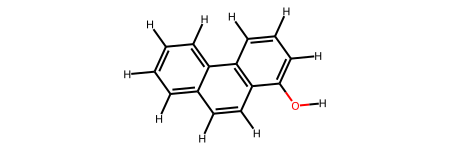

In [1]:
import isicle

geom = isicle.load("C1=CC=C2C(=C1)C=CC3=C2C=CC=C3O")
geom.view()

We can additionally perform an initial forcefield optimization to produce 3D, rather than 2D, coordinates for the molecule.
Keyword arguments include whether to `embed` the molecule (only specify `False` if the molecule has already been embedded), the `forcefield` used to perform the optimization (here, `UFF`), and the number of forcefield iterations, `ff_iter`, here 200.
Because our selected molecule is planar, differences will be minimal.

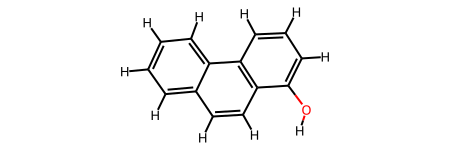

In [2]:
geom = geom.initial_optimize(embed=True, forcefield="UFF", ff_iter=200)
geom.view()

### Adduct generation
To generate adducts, the ionic form of the molecule observed under an ion mobility experiment, we ionize the molecule with H+ using the `explicit` method to explicitly ionize indicated sites with indicated ions. 
We specify the ion(s) in the `ion_list` and the atom types to be ionized in `element_list`.
Multiple ionizations by monoatomic ions is possible by repeating the ionize function on a given molecule. At this time, polyatomic ions are not supported. 

In [3]:
# Ionize oxygen
adducts = geom.ionize(method='explicit', ion_list=['H-'], element_list=['O'])
adducts.get_adducts()

{'H-': {0: <isicle.geometry.Geometry object at 0x2ae1c7eb4950>}}

Note that `get_adducts` returns a nested dictionary keyed by ion type (here `H-`) and unique index to distinguish multiple ion sites (here, `0`).
Alternatively, `get_structures` returns a flattened list of all adduct structures in the object.

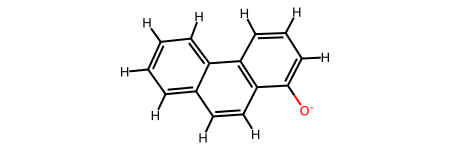

In [4]:
adduct = adducts.get_adducts()["H-"][0]

# Alternatively
adduct = adducts.get_structures()[0]

adduct.view()

### Semiemprical optimization
While we must obtain 3D coordinates for subsequent steps, use of a classic forcefield is not the most rigorous way to do so.
Instead, we can leverage semiemprical approaches developed within xTB (extended tight binding), specifically the GFN2-xTB forcefield.
In this case, the result of classic forcefield and semiempircal methods are quite similar, but expect these to diverge with more complex structures.

In [5]:
md = isicle.md.md(adduct, task='optimize', forcefield='gfn2', optlevel='vtight')
md.result.keys()

dict_keys(['out', 'charges', 'wbo', 'log', 'xtbrestart', 'mol', 'final'])

ISiCLE runs the relevant xTB code in a temporary directory, returning to the user a dictionary with all raw outputs stored. 
To parse this information into more a more readily usable form, we can initialize and run the associated file parser.

In [6]:
md_parsed = md.parse()
md_parsed.keys()

dict_keys(['protocol', 'geometry', 'timing', 'energy'])

We can now view the xTB protocol, timing information, energy, and the optimized geometry.

protocol:   xtb GTBXZWADMKOZQJ-UHFFFAOYSA-N.xyz --opt vtight --gfn2 --chrg -1
timing:  {'Total wall time': '0d,0h,0min,0.206sec', 'SCF wall time': '0d,0h,0min,0.026sec', 'ANC optimizer wall time': '0d,0h,0min,0.206sec'}
energy:  {'Total energy': '-38.854921356681 Hartrees'}


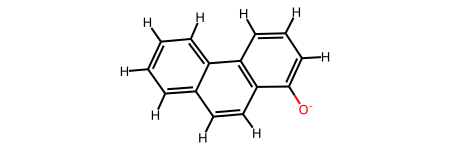

In [7]:
print('protocol: ', md_parsed['protocol'])
print('timing: ', md_parsed['timing'])
print('energy: ', md_parsed['energy'])
md_parsed['geometry'].view()

Finally, we'll reassign our `adduct` variable with the MD-optimized adduct.

In [8]:
adduct = md_parsed['geometry']

### Conformational Ensembles
We use xTB's Conformer Rotamer Ensemble Sampling Tool, CREST, to predict conformational ensembles.
CREST is already a simple-to-use, standalone commandline tool, but we have created a Python interface to call upon some tools CREST has made available, as well as functionality to obtain relevant outputs.
For example, we can generate conformers using a 3 kcal/mol energy window using the GFN2 forcefield.

In [9]:
crest = isicle.md.md(
    adduct, 
    task='conformer',
    forcefield='gfn2',
    optlevel='normal',
    ewin=3,
    processes=8
)

Raw output returned as a dictionary:

In [10]:
crest.result.keys()

dict_keys(['best', 'conformers', 'rotamers', 'out', 'coord', 'cre_members', 'energies', 'restart', 'mdrestart', 'trj', 'log', 'gfnff_adjacency', 'gfnff_topo', 'wbo'])

Parse the result:

In [11]:
crest_parsed = crest.parse()
crest_parsed.keys()

dict_keys(['protocol', 'geometry', 'timing', 'energy'])

protocol:   $ crest /scratch/colb804/isicle/tmp50vh4igd/GTBXZWADMKOZQJ-UHFFFAOYSA-N.xyz -chrg -1 --ewin 3 --optlevel normal -gfn2 -T 8
timing:  {'CREST runtime (total)': {'days': 0, 'hours': 0, 'minutes': 3, 'seconds': 6.93}, 'Trial metadynamics (MTD)': {'days': 0, 'hours': 0, 'minutes': 0, 'seconds': 3.649}, 'Metadynamics (MTD)': {'days': 0, 'hours': 0, 'minutes': 1, 'seconds': 18.813}, 'Geometry optimization': {'days': 0, 'hours': 0, 'minutes': 0, 'seconds': 46.338}, 'Molecular dynamics (MD)': {'days': 0, 'hours': 0, 'minutes': 0, 'seconds': 57.897}, 'Genetic crossing (GC)': {'days': 0, 'hours': 0, 'minutes': 0, 'seconds': 0.0}, 'I/O and setup': {'days': 0, 'hours': 0, 'minutes': 0, 'seconds': 0.232}}
energy:  {'relative energies': [], 'total energies': [], 'population': []}


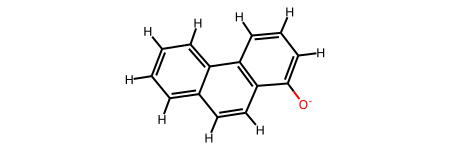

In [12]:
print('protocol: ', crest_parsed['protocol'])
print('timing: ', crest_parsed['timing'])
print('energy: ', crest_parsed['energy'])
crest_parsed['geometry']['best'].view()

Finally, we'll grab all generated conformers for the next step.

In [13]:
conformers = crest_parsed['geometry']['conformers']
conformers

### Density Functional Theory Calculations

We now calculate DFT single point energies for each conformer using open-source quantum chemical software, ORCA.
Specifications are customizable to any functional or basis set available, but defaults are set to B3LYP and 6-31G(d), respectively.

Here we calculate the geometry optimizations and single point energies using the hybrid functional, B3LYP, and double zeta basis set, def2-SVP, along with some other optimizations.
We can either loop through each CREST conformer, invoking `isicle.qm.dft`, or make use of `ConformationalEnsemble` to map over conformers.

In [15]:
conformers = isicle.conformers.ConformationalEnsemble([conformers])

In [16]:
dft = conformers.apply(
    func=isicle.qm.dft,
    backend='orca',
    simple_input=[
        'b3lyp',      # Functional
        'def2-svp',   # Basis set
        'def2/j',     # Auxillary basis set
        'opt',        # Perform geometry optimization
        'd3bj',       # Dispersion correction
    ],
    spin_multiplicity=1,
    processes=8
)

Raw outputs include the following:

In [17]:
dft[0].result.keys()

dict_keys(['xyz', 'inp', 'out', 'log', 'txt', 'gbw', 'opt', 'bibtex', 'densities', 'densitiesinfo', 'trj', 'engrad'])

Parse the result:

In [18]:
dft_parsed = [x.parse() for x in dft]
dft_parsed[0].keys()

dict_keys(['protocol', 'geometry', 'energy', 'orbital_energies', 'charge', 'timing', 'success'])

protocol:  ! b3lyp def2-svp def2/j opt d3bj
%PAL NPROCS 8 END
* xyzfile -1 1 /scratch/colb804/isicle/tmp7t6d6p2s/GTBXZWADMKOZQJ-UHFFFAOYSA-N.xyz

timing:  {'Sum of individual times': 131.993, 'Startup calculation': 10.562, 'SCF iterations': 71.833, 'Property calculations': 0.569, 'SCF Gradient evaluation': 48.99, 'Geometry relaxation': 0.039, 'Total run time': {'days': 0, 'hours': 0, 'minutes': 2, 'seconds': 14, 'msec': 710}}
energy:  -613.443313909566


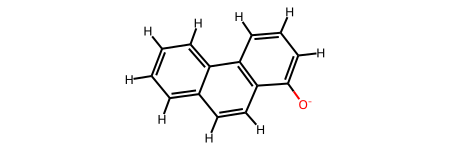

In [19]:
print('protocol: ', dft_parsed[0]['protocol'])
print('timing: ', dft_parsed[0]['timing'])
print('energy: ', dft_parsed[0]['energy'])
dft_parsed[0]['geometry'].view()

Grab all of the geometries:

In [20]:
conformers = isicle.conformers.ConformationalEnsemble([x["geometry"] for x in dft_parsed])

### Collision Cross Section Calculations

Next, we calculate the collision cross section for our optimized geometry produced from the DFT step using using a refactored version of MOBCAL for trajectory-based mobility calculations.
This version is included in the with installation of ISiCLE and improves upon the original verion's computational efficiency by two orders of magnitude. (Note: currently only supported on Linux).
We conduct the calculation in nitrogen gas at room temperature using the Lennard-Jones potential.

In [21]:
mobility = conformers.apply(
    isicle.mobility.calculate_ccs,
    lennard_jones='default',
    i2=5013489,
    buffer_gas='nitrogen',
    buffer_gas_mass=28.014,
    temp=300,
    ipr=1000,
    itn=10,
    inp=48,
    imp=1024,
    processes=8,
)

Raw outputs include the following:

In [22]:
mobility[0].result.keys()

dict_keys(['mfj', 'in', 'params', 'log', 'out', 'geometry'])

Parse the result:

In [24]:
mobility_parsed = [x.parse() for x in mobility]
mobility_parsed[0].keys()

dict_keys(['ccs', 'geometry'])

Grab all of the geometries:

In [25]:
conformers = isicle.conformers.ConformationalEnsemble([x["geometry"] for x in mobility_parsed])

### Boltzmann Averaging CCS Values
To obtain our Boltzmann weighted CCS values, we Boltzmann average across the different conformers by their DFT energies. This is accomplished using the `conformers` module. Because we only have a single conformer in this example, standard deviation is zero.

In [26]:
ccs = conformers.reduce("ccs", func='boltzmann')
ccs

mean    137.3965
std       0.0000
n         1.0000
Name: 0, dtype: float64